# Ubiquant Market Prediction
投資の収益率を予測するモデルを構築<br>

- **row_id**
- **time_id** - 0~1219
- **investment_id** - 0~3773
- **target** - The target.
- **features** - [f_0:f_299] - 市場データより生成された特徴量

データの確認 ～ 提出コードの確認まで行っていきます。

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc 
import warnings
import os
warnings.filterwarnings('ignore')

### 学習データ読み込み
提供されているCSV学習データの容量は18Gほどあります。そのままでは大き過ぎるので、Daskで読み込むかpickleやparquetで扱うことになりそうです。<br>
今回は、ROB MULLAさんのParquetデータを使用させていただきます。感謝です！<br>
参考カーネル：[⏫ Fast Data Loading and Low Mem with Parquet Files](https://www.kaggle.com/robikscube/fast-data-loading-and-low-mem-with-parquet-files)

In [9]:
os.chdir("../ubiquant/input")

path = os.getcwd()
print(path)

C:\Users\yamap\ubiquant\input


In [10]:
%%time
df_train = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')
df_train

Wall time: 26.2 s


,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,1219_3768,1219,3768,0.033600,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,1219_3769,1219,3769,-0.223264,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,1219_3770,1219,3770,-0.559415,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,1219_3772,1219,3772,0.009599,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 3.6+ GB


In [11]:
df_train.isnull().sum()

row_id           0
time_id          0
investment_id    0
target           0
f_0              0
                ..
f_295            0
f_296            0
f_297            0
f_298            0
f_299            0
Length: 304, dtype: int64

In [4]:
df_train.loc[:, 'row_id':'f_3'].describe()

,time_id,investment_id,target,f_0,f_1,f_2,f_3
count,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,6.654862e+02,1.885265e+03,-2.109159e-02,1.637057e-03,-1.257678e-02,8.514749e-03,-2.003703e-02
std,3.560434e+02,1.083616e+03,9.176629e-01,1.079721e+00,1.030980e+00,1.030281e+00,9.602916e-01
min,0.000000e+00,0.000000e+00,-9.419646e+00,-1.765789e+01,-6.579473e+00,-8.644268e+00,-1.800427e+01
25%,3.530000e+02,9.520000e+02,-5.004572e-01,-4.071441e-01,-6.813878e-01,-6.530838e-01,-4.496046e-01
50%,7.040000e+02,1.882000e+03,-9.717009e-02,2.431158e-01,-4.867587e-02,4.350941e-02,-2.639937e-01
75%,9.750000e+02,2.830000e+03,3.572908e-01,6.649507e-01,6.086557e-01,6.587324e-01,7.763371e-02
max,1.219000e+03,3.773000e+03,1.203861e+01,7.845261e+00,8.707207e+00,8.009340e+00,4.706333e+01


データ数を確認してみます。欠損ありますね。<br>
time_idについては、idが大きいほどデータがそろっている、また300後半でかなりデータの抜けがあります。<br>
investment_idは、bin数を増やすとボコボコしてるのが確認できました。

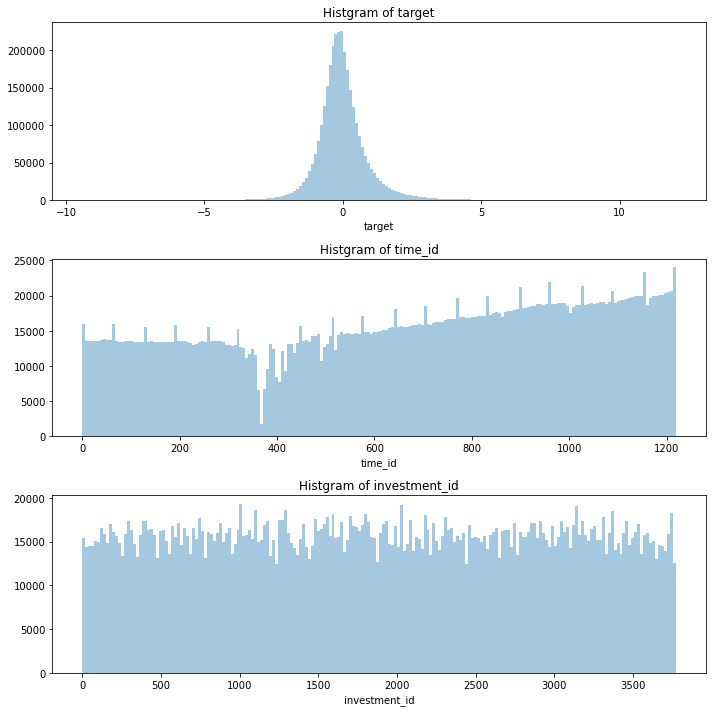

In [13]:
f, ax = plt.subplots(3,1,figsize=(10,10))
sns.distplot(df_train['target'], ax=ax[0], bins=200, kde=False)
ax[0].set_title('Histgram of target')

sns.distplot(df_train['time_id'], ax=ax[1], bins=200, kde=False)
ax[1].set_title('Histgram of time_id')

sns.distplot(df_train['investment_id'], ax=ax[2], bins=200, kde=False)
ax[2].set_title('Histgram of investment_id')

plt.tight_layout()

In [14]:
df_o1100 = df_train[df_train.time_id>=1100]
df_o1100.count()

row_id           397593
time_id          397593
investment_id    397593
target           397593
f_0              397593
                  ...  
f_295            397593
f_296            397593
f_297            397593
f_298            397593
f_299            397593
Length: 304, dtype: int64

### 提出確認
ubiquant Python moduleを使用する必要があるとのこと。簡易モデルで提出の確認だけしておきます。<br>
[Overview/Evaluation](https://www.kaggle.com/c/ubiquant-market-prediction/overview/evaluation)に記載の通り、predictionを行います。

[1]	valid_0's rmse: 0.902892
[2]	valid_0's rmse: 0.90231
[3]	valid_0's rmse: 0.901959
[4]	valid_0's rmse: 0.901832
[5]	valid_0's rmse: 0.901808
[6]	valid_0's rmse: 0.901598
[7]	valid_0's rmse: 0.901488
[8]	valid_0's rmse: 0.901223
[9]	valid_0's rmse: 0.901139
[10]	valid_0's rmse: 0.900948
[11]	valid_0's rmse: 0.900904
[12]	valid_0's rmse: 0.900803
[13]	valid_0's rmse: 0.900843
[14]	valid_0's rmse: 0.900793
[15]	valid_0's rmse: 0.900861
[16]	valid_0's rmse: 0.900841
[17]	valid_0's rmse: 0.900703
[18]	valid_0's rmse: 0.90087
[19]	valid_0's rmse: 0.900873
[20]	valid_0's rmse: 0.900927
[21]	valid_0's rmse: 0.900837
[22]	valid_0's rmse: 0.900695
[23]	valid_0's rmse: 0.9007
[24]	valid_0's rmse: 0.900807
[25]	valid_0's rmse: 0.900914
[26]	valid_0's rmse: 0.900892
[27]	valid_0's rmse: 0.900954
[28]	valid_0's rmse: 0.901057
[29]	valid_0's rmse: 0.901154
[30]	valid_0's rmse: 0.901208
[31]	valid_0's rmse: 0.901048
[32]	valid_0's rmse: 0.900972
[33]	valid_0's rmse: 0.900965
[34]	valid_0's rmse: 0.

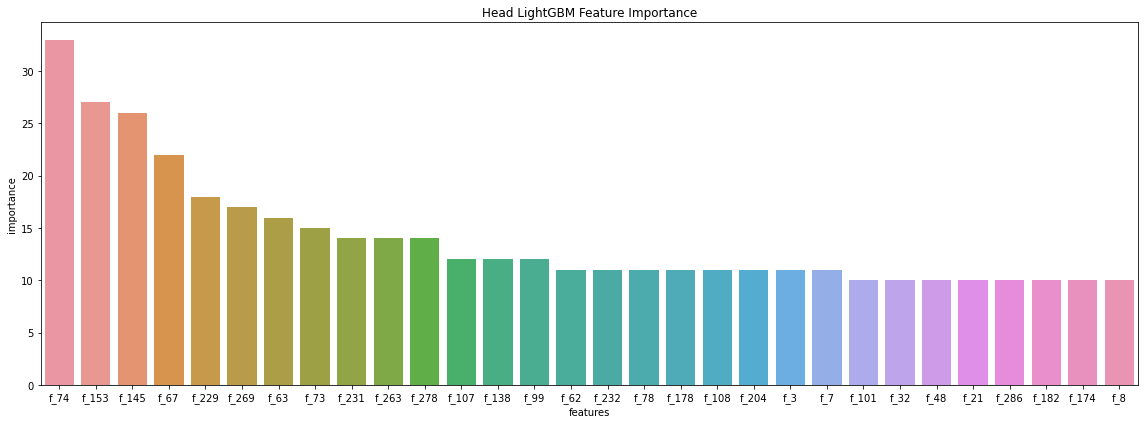

In [15]:
df_u300 = df_train[df_train.time_id<=300]
df_o1100 = df_train[df_train.time_id>=1100]

del df_train

features = ['f_'+str(i) for i in range(300)]
target = 'target'

# 学習に使用するデータを設定
data_train = lgb.Dataset(df_u300[features], df_u300[target])
data_eval = lgb.Dataset(df_o1100[features], df_o1100[target], reference=data_train) 

# LightGBM parameters
params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": 14,
        "max_depth": 4,
        "feature_fraction": 0.8,
        "subsample_freq": 1,
        "bagging_fraction": 0.7,
        "min_data_in_leaf": 10,
        "learning_rate": 0.2,
        "boosting": "gbdt",
        "lambda_l1": 0.4,
        "lambda_l2": 0.4,
        "verbosity": -1,
        "random_state": 42,
}

# モデルの学習
model = lgb.train(params,
                  train_set=data_train, # トレーニングデータの指定
                  valid_sets=data_eval, # 検証データの指定
                  )
df_feature = pd.DataFrame({
    'features' :features,
    'importance' : model.feature_importance()})
df_feature = df_feature.sort_values(by='importance',ascending = False)

plt.figure(figsize=(16, 6))
sns.barplot(x='features', y='importance', data=df_feature[0:30])
plt.title(f'Head LightGBM Feature Importance')
plt.tight_layout()
plt.show()

In [16]:
import ubiquant

env = ubiquant.make_env()  # initialize the environment
iter_test = env.iter_test()  # an iterator which loops over the test set and sample submission

for (test_df, sample_prediction_df) in iter_test:
    sample_prediction_df['target'] = model.predict(test_df[features])  # make your predictions here
    env.predict(sample_prediction_df)   # register your predictions

ModuleNotFoundError: No module named 'ubiquant'